# Facebook DETR
In this small toy project on Jupyter Notebook, I'm learning to leverage the <a href="https://github.com/facebookresearch/detr">Facebook DETR</a>, an end-to-end object detection with transformers, in detecting and labeling objects in the image and will be outputing an image with the bouding boxes. I'll be using the pre-trained ResNet-101 model as used in the tutorial.

---

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

import requests
from PIL import Image, ImageDraw, ImageFont

Convolutional neural network-related projects can utilize GPU to accelerate the image processing speed. In this project with Facebook DETR, which is an end-to-end object detection with transformers in detecting and labeling objects in an image, we can check to see if CUDA is available for applying GPU on this small piece of work.

In [2]:
if (torch.cuda.is_available()):
    print("CUDA is available!")

CUDA is available!


As I'm using a ROG laptop which comes with a GPU that supports CUDA, I am able to set my device and model to using it with <code>.cuda()</code>. However, in case your device or service hosting platform (i.e. Heroku) does not have GPU support, you would need to go with working only with CPU. 

A common way of doing this is to set the device and other things to CUDA if it's available, otherwise set it to CPU, as shown in the following cell.

In [3]:
# Utilize CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Facebook DETR model
model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()
model = model.cuda() # Remove this line if CUDA is not available

Using cache found in C:\Users\Kevin C/.cache\torch\hub\facebookresearch_detr_master


In [4]:
# Mean and std from the ImageNet dataset
mean = np.array([0.485, 0.456, 0.496])
std = np.array([0.229, 0.224, 0.225])

# Standard PyTorch input image normalization
transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

CLASSES_SET = set(CLASSES)

Since the pre-trained model used in this example is a ResNet-101 model trained on ImageNet, we would need to apply transformation to the fed image. The above cell includes a sample of typical PyTorch input image normalization, which will resize the image, transform it into a tensor, and apply normalization accordingly.

The classes used by the model is also included in the <code>CLASSES</code> list. It's a pretty short list with very limited number of class labels. Ideally, we can apply transfer learning to the pre-trained model to make it fit to more classes, but for the purpose of this small toy project, we are not going to do that.

In [5]:
# Function that uses the pre-trained model to make prediction
def make_prediction(url):
    # Open image from URL and transform it into a tensor
    img = Image.open(requests.get(url, stream=True).raw).resize((800,600))
    img_tensor = transform(img).unsqueeze(0).cuda()
    
    # Makes prediction
    with torch.no_grad():
        output = model(img_tensor)
        
    pred_logits = output['pred_logits'][0][:, :len(CLASSES)]
    pred_boxes = output['pred_boxes'][0]

    # Perform softmax on predicted logits
    max_output = pred_logits.softmax(-1).max(-1)
    topk = max_output.values.topk(5)
    
    # Get only the top K logits and bounding boxes
    pred_logits = pred_logits[topk.indices]
    pred_boxes = pred_boxes[topk.indices]
    
    img2 = img.copy()  # Make a copy of the original image for us to play with
    drw = ImageDraw.Draw(img2)

    for logits, boxes in zip(pred_logits, pred_boxes):
        cls = logits.argmax() # Get the predicted class
        if cls >= len(CLASSES):
            continue
        label = CLASSES[cls] # Get the label
        # print(label)

        # Draw the bounding boxes on the image   
        boxes = boxes.cpu() * torch.Tensor([800, 600, 800, 600])
        x, y, w, h = boxes
        x0, x1 = x-w//2, x+w//2
        y0, y1 = y-h//2, y+h//2
        drw.rectangle([x0, y0, x1, y1], outline='red', width=3)
        font_size = 16
        font = ImageFont.truetype("arial.ttf", font_size)
        drw.text((x0, y0), label, fill='white', font=font)

    return img2

With everything all ready, we can now take in an input URL to the image, make predictions (detect objects in the image), and output it with bouding boxes aroudn the objects. Be noted again that the model is only able to detect a limited number of classes.

https://img.global.news.samsung.com/tw/wp-content/uploads/2020/05/Smart-TV-Tips_main1.jpg


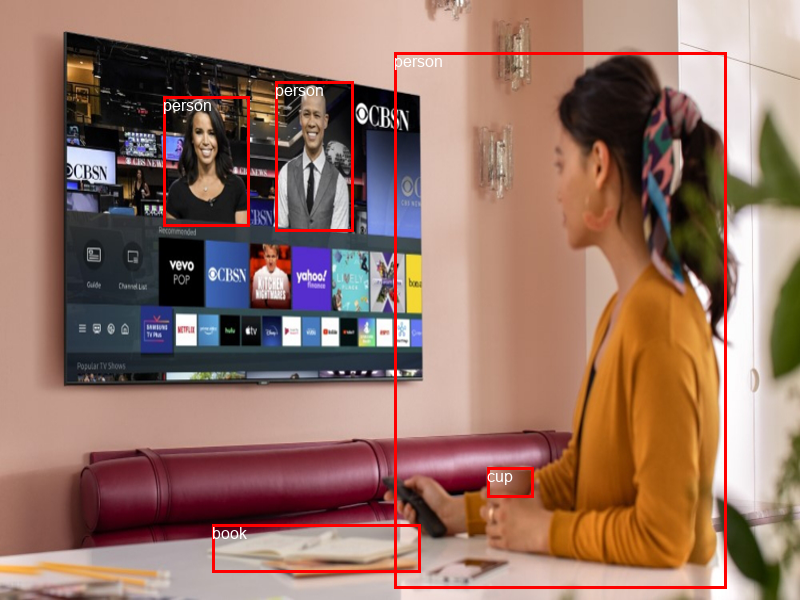

In [6]:
# Input image address
url = input()

img = make_prediction(url)
img